In [1]:
import pandas as pd
import numpy as np
from stockstats import StockDataFrame as Sdf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from preprocess.dataloader import load_data, clean_data
from preprocess.data_generator import generate_trading_data
from preprocess.indicator_factory import add_indicators_all, add_indicators
from evals import eval_trend_return_acc
from utils.date_util import get_current_report_quarter
from valuation_loader import estimate_price

import torch
from datetime import datetime

In [2]:
# Backtest scenario:

# Input: testing period: (start_test_date - end_test_date)
#        all_data: loading stock data, must including test period and some time before to calculate MA20
#        stock_list: list of all stocks
#        stock_infos: basic df of information of the stocks, including their exchanges and industry
#        filters: there are three filters used in this backtest: CANSLIM, intrinsic_values and FA_scoring

#Output: simulation of n backtesting scenario, each scenario follows the strategy: 5 stock max, each stock 
# is allocated with equal position (20% NAV), sell when reach trailing stoploss (7%); each scenario is able 
# to visualize the line and important metrics (win_rate, sharpe_ratio, e.t.c)


In [3]:
import os, random, time

seed = 42
os.environ['PYTHONHASHSEED'] = str(seed)
# Torch RNG
# torch.manual_seed(seed)
# torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)
# Python RNG
np.random.seed(seed)
random.seed(seed)

torch.backends.cudnn.benchmark=False
torch.backends.cudnn.deterministic=True
torch.backends.cudnn.enabled=False

os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":16:8"
os.environ['TZ'] = 'Asia/Saigon'
time.tzset()

In [4]:
data_src = "data/Vietnam"
stock_list = np.load(data_src + "/list_stocks.npy", allow_pickle = True)
stock_infos = pd.read_csv("data/Vietnam/stock_infos.csv", index_col = "ticker")
price_estimator_pe = pd.read_csv(data_src + "/estimate_price_pe.csv")
price_estimator_pb = pd.read_csv(data_src + "/estimate_price_pb.csv")
price_estimator = estimate_price(stock_list, stock_infos, price_estimator_pe, price_estimator_pb)
price_estimator.to_csv(data_src + "/estimate_price.csv")



In [5]:
from preprocess.dataloader import load_data, clean_data
from preprocess.data_generator import generate_trading_data
from datetime import datetime
from utils.date_util import get_most_recent_trade_day
from pytz import timezone

stock_data = {}

# start_data_date = datetime.strptime("2020-02-10 09:00:00", '%Y-%m-%d %H:%M:%S')
start_data_date = datetime.strptime("2021-02-01", '%Y-%m-%d')
# start_data_date = datetime.strptime("2018-10-01 09:00:00", '%Y-%m-%d %H:%M:%S')
# now = datetime.now(timezone('Europe/Berlin')).replace(tzinfo=None) 
end_data_date = datetime.strptime("2023-01-30", '%Y-%m-%d')
# end_data_date = get_most_recent_trade_day(now)[0]
ohclv_data_src = "data/Vietnam/OHCLV"
interval = "1day"
periods = [5, 20]
indicators = ["MACD", "rsi", "mfi", "close_sma", "volume_sma", "rs", "boll", "psar"]

stocks = []

for stock in stock_list:            
    source_df = load_data(stock, ohclv_data_src, interval, start_data_date, end_data_date)      
    if start_data_date != source_df.index[0]:
        print("Remove {} because of missing data".format(stock))
    else:
        stocks.append(stock)
        stock_data[stock] = source_df
        
    if len(stocks) == 0:
        print("Error: the start data date is invalid, please check if it is a weekend or holiday")

    stock_data = clean_data(stock_data, stocks)

# daily_data_storage, daily_features_storage = add_indicators_all(stock_data, indicators, periods = periods, trend_ahead = 5)


SHB is missing at: ['2021-10-06T00:00:00.000000000' '2021-10-07T00:00:00.000000000'
 '2021-10-08T00:00:00.000000000']
VND is missing at: ['2021-03-31T00:00:00.000000000' '2021-04-01T00:00:00.000000000'
 '2021-04-02T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000']
PAN is missing at: ['2021-04-13T00:00:00.000000000' '2021-04-14T00:00:00.000000000'
 '2021-04-15T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000'
 '2021-09-06T00:00:00.000000000']
TVB is missing at: ['2021-04-13T00:00:00.000000000' '2021-04-14T00:00:00.000000000'
 '2021-04-15T00:00:00.000000000' '2021-08-30T00:00:00.000000000'
 '2021-08-31T00:00:00.000000000' '2021-09-01T00:00:00.000000000']


In [6]:
# #Load VNI data

# vni_df = load_data("VNINDEX", ohclv_data_src, interval, start_data_date, end_data_date)    
# vni_df, features = add_indicators(vni_df, indicators, periods, trend_ahead = 5)



In [7]:
# start_test_date = datetime.strptime("2019-02-15 09:00:00", '%Y-%m-%d %H:%M:%S')
# start_test_date = datetime.strptime("2022-02-15 09:00:00", '%Y-%m-%d %H:%M:%S')
# start_test_date = datetime.strptime("2020-06-15 09:00:00", '%Y-%m-%d %H:%M:%S')
start_test_date = datetime.strptime("2021-07-01", '%Y-%m-%d')
end_test_date = end_data_date


X_test_storage = []
y_test_storage = []
df_test_storage = []
target_col = "trend_return"
setting = "many_to_many"
daily_history_window = 20
light_indicators = ["MACD", "rsi", "mfi", "close_sma", "volume_sma", "rs", "boll", "psar"]
light_daily_data_storage, light_daily_features_storage = add_indicators_all(stock_data, light_indicators, periods = periods, trend_ahead = 5)

for ticker in stocks:
    
    X_test, y_test, df_test = generate_trading_data(light_daily_data_storage[ticker], light_daily_features_storage[ticker], target_col, daily_history_window, start_test_date, end_test_date, setting = setting)
    X_test_storage.append(X_test)
    y_test_storage.append(y_test)
    df_test_storage.append(df_test)

In [8]:
from preprocess.dataloader import prepare_env_df
from backtest.backtest_light import Backtest
from tqdm import tqdm

In [9]:
test_env_df = prepare_env_df(df_test_storage)
trade_sessions = test_env_df["date"].unique()

num_test_day = len(trade_sessions)
num_stock = len(stock_list)

#Initialize the test_preds of the shape (num_test_date, len_stocks). 
#test_preds[i, j] indicates the probability of stock j is bought at day i
#As no learning model is used, the test_preds is initialized with 1 and threshold is 0.5 (always possible to buy)

test_preds = np.ones((num_test_day, len(stocks)))
thresholds =  np.array([0.5] * len(stocks))

In [10]:
test_env_df

,date,symbol,open,high,low,close,volume,ticker,close_sma_5,close_sma_5_ratio,...,close_r,volume_r,daily_return,stability,trend_return,trend_log_return,trend,agg_changes,rs,rs_change
0,2021-07-01,HOSE:VCB,"116,700.000","116,800.000","115,000.000","116,400.000","2,056,400.000",VCB,"114,400.000",0.017,...,0.000,-0.384,0.000,0.015,-0.046,-0.048,2,0.210,0.520,0.520
1,2021-07-02,HOSE:VCB,"116,400.000","116,600.000","114,000.000","114,900.000","1,767,290.000",VCB,"114,860.000",0.000,...,-0.013,-0.141,-0.013,0.016,-0.044,-0.045,2,0.144,0.450,-0.070
2,2021-07-05,HOSE:VCB,"113,900.000","113,900.000","110,900.000","113,600.000","2,416,000.000",VCB,"115,060.000",-0.013,...,-0.011,0.367,-0.011,0.013,-0.057,-0.059,2,0.122,0.440,-0.010
3,2021-07-06,HOSE:VCB,"112,500.000","115,000.000","112,000.000","112,000.000","1,754,600.000",VCB,"114,660.000",-0.023,...,-0.014,-0.274,-0.014,0.012,-0.077,-0.080,2,0.108,0.520,0.080
4,2021-07-07,HOSE:VCB,"112,000.000","113,400.000","106,000.000","113,400.000","2,808,000.000",VCB,"114,060.000",-0.006,...,0.012,0.600,0.012,0.014,-0.102,-0.108,2,0.125,0.530,0.010
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
81159,2023-01-17,HOSE:VPH,"4,000.000","4,090.000","3,980.000","4,050.000","156,700.000",VPH,"4,072.000",-0.005,...,-0.005,1.325,-0.005,0.020,NaN,NaN,0,-0.327,0.060,-0.040
81160,2023-01-18,HOSE:VPH,"4,050.000","4,150.000","4,000.000","4,060.000","56,200.000",VPH,"4,064.000",-0.001,...,0.002,-0.641,0.002,0.009,NaN,NaN,0,-0.316,0.050,-0.010
81161,2023-01-19,HOSE:VPH,"4,180.000","4,200.000","4,060.000","4,100.000","64,000.000",VPH,"4,076.000",0.006,...,0.010,0.139,0.010,0.009,NaN,NaN,0,-0.281,0.060,0.010
81162,2023-01-27,HOSE:VPH,"4,140.000","4,230.000","4,140.000","4,150.000","88,800.000",VPH,"4,086.000",0.016,...,0.012,0.387,0.012,0.010,NaN,NaN,0,-0.261,0.050,-0.010


In [11]:
# 3 filters are applied here. For each trading day, only the stocks that satisfy all 3 filters are allowed to buy

filters = ["CANSLIM","TA_scoring"]
backtest = Backtest(test_env_df, stock_infos, test_preds[:, :], filters, max_number_of_stock = 5, buy_thresholds = thresholds, sell_thresholds = -thresholds, ta_score_threshold = 4, t_delay = 2)


In [12]:
backtest.execute(num_test = 1000)

  0%|                                          | 1/1000 [00:00<02:02,  8.15it/s]

Test 0


  1%|▍                                        | 11/1000 [00:01<02:00,  8.19it/s]

Test 10


  2%|▊                                        | 21/1000 [00:02<01:48,  9.06it/s]

Test 20


  3%|█▎                                       | 31/1000 [00:03<01:45,  9.19it/s]

Test 30


  4%|█▋                                       | 41/1000 [00:04<01:44,  9.19it/s]

Test 40


  5%|██                                       | 51/1000 [00:05<01:54,  8.30it/s]

Test 50


  6%|██▌                                      | 61/1000 [00:07<02:00,  7.82it/s]

Test 60


  7%|██▉                                      | 71/1000 [00:08<02:15,  6.86it/s]

Test 70


  8%|███▎                                     | 81/1000 [00:09<02:12,  6.92it/s]

Test 80


  9%|███▋                                     | 91/1000 [00:11<01:55,  7.87it/s]

Test 90


 10%|████                                    | 101/1000 [00:12<01:54,  7.87it/s]

Test 100


 11%|████▍                                   | 111/1000 [00:13<01:52,  7.87it/s]

Test 110


 12%|████▊                                   | 121/1000 [00:14<01:51,  7.87it/s]

Test 120


 13%|█████▏                                  | 131/1000 [00:16<01:50,  7.89it/s]

Test 130


 14%|█████▋                                  | 141/1000 [00:17<01:48,  7.93it/s]

Test 140


 15%|██████                                  | 151/1000 [00:18<01:48,  7.83it/s]

Test 150


 16%|██████▍                                 | 161/1000 [00:20<01:47,  7.79it/s]

Test 160


 17%|██████▊                                 | 171/1000 [00:21<01:46,  7.79it/s]

Test 170


 18%|███████▏                                | 181/1000 [00:22<01:43,  7.88it/s]

Test 180


 19%|███████▋                                | 192/1000 [00:23<01:20, 10.00it/s]

Test 190


 20%|████████                                | 201/1000 [00:24<01:17, 10.25it/s]

Test 200


 21%|████████▍                               | 211/1000 [00:25<01:17, 10.21it/s]

Test 210


 22%|████████▊                               | 221/1000 [00:26<01:16, 10.24it/s]

Test 220


 23%|█████████▏                              | 231/1000 [00:27<01:15, 10.18it/s]

Test 230


 24%|█████████▋                              | 241/1000 [00:28<01:14, 10.21it/s]

Test 240


 25%|██████████                              | 251/1000 [00:29<01:13, 10.20it/s]

Test 250


 26%|██████████▍                             | 261/1000 [00:30<01:23,  8.84it/s]

Test 260


 27%|██████████▊                             | 271/1000 [00:31<01:22,  8.82it/s]

Test 270


 28%|███████████▏                            | 281/1000 [00:32<01:20,  8.88it/s]

Test 280


 29%|███████████▋                            | 291/1000 [00:34<01:20,  8.77it/s]

Test 290


 30%|████████████                            | 301/1000 [00:35<01:18,  8.96it/s]

Test 300


 31%|████████████▍                           | 311/1000 [00:36<01:17,  8.92it/s]

Test 310


 32%|████████████▊                           | 321/1000 [00:37<01:25,  7.96it/s]

Test 320


 33%|█████████████▏                          | 331/1000 [00:38<01:21,  8.22it/s]

Test 330


 34%|█████████████▋                          | 341/1000 [00:40<01:28,  7.45it/s]

Test 340


 35%|██████████████                          | 351/1000 [00:41<01:18,  8.23it/s]

Test 350


 36%|██████████████▍                         | 361/1000 [00:42<01:18,  8.19it/s]

Test 360


 37%|██████████████▊                         | 371/1000 [00:43<01:16,  8.24it/s]

Test 370


 38%|███████████████▏                        | 381/1000 [00:45<01:19,  7.83it/s]

Test 380


 39%|███████████████▋                        | 391/1000 [00:46<01:13,  8.29it/s]

Test 390


 40%|████████████████                        | 401/1000 [00:47<01:12,  8.25it/s]

Test 400


 41%|████████████████▍                       | 411/1000 [00:48<01:11,  8.27it/s]

Test 410


 42%|████████████████▊                       | 421/1000 [00:49<01:10,  8.22it/s]

Test 420


 43%|█████████████████▏                      | 431/1000 [00:51<01:12,  7.88it/s]

Test 430


 44%|█████████████████▋                      | 441/1000 [00:52<01:10,  7.94it/s]

Test 440


 45%|██████████████████                      | 451/1000 [00:53<01:10,  7.79it/s]

Test 450


 46%|██████████████████▍                     | 461/1000 [00:55<01:10,  7.66it/s]

Test 460


 47%|██████████████████▊                     | 471/1000 [00:56<01:08,  7.73it/s]

Test 470


 48%|███████████████████▏                    | 481/1000 [00:57<01:06,  7.77it/s]

Test 480


 49%|███████████████████▋                    | 491/1000 [00:58<01:04,  7.93it/s]

Test 490


 50%|████████████████████                    | 501/1000 [01:00<01:03,  7.89it/s]

Test 500


 51%|████████████████████▍                   | 511/1000 [01:01<01:01,  7.92it/s]

Test 510


 52%|████████████████████▊                   | 521/1000 [01:02<01:00,  7.90it/s]

Test 520


 53%|█████████████████████▏                  | 531/1000 [01:03<01:00,  7.80it/s]

Test 530


 54%|█████████████████████▋                  | 541/1000 [01:05<00:57,  7.98it/s]

Test 540


 55%|██████████████████████                  | 551/1000 [01:06<00:56,  7.98it/s]

Test 550


 56%|██████████████████████▍                 | 561/1000 [01:07<00:55,  7.95it/s]

Test 560


 57%|██████████████████████▊                 | 571/1000 [01:08<00:53,  8.01it/s]

Test 570


 58%|███████████████████████▏                | 581/1000 [01:10<00:52,  7.97it/s]

Test 580


 59%|███████████████████████▋                | 591/1000 [01:11<00:45,  8.98it/s]

Test 590


 60%|████████████████████████                | 601/1000 [01:12<00:42,  9.29it/s]

Test 600


 61%|████████████████████████▍               | 611/1000 [01:13<00:49,  7.84it/s]

Test 610


 62%|████████████████████████▊               | 621/1000 [01:14<00:47,  7.92it/s]

Test 620


 63%|█████████████████████████▏              | 630/1000 [01:16<00:54,  6.80it/s]

Test 630


 64%|█████████████████████████▋              | 641/1000 [01:17<00:46,  7.78it/s]

Test 640


 65%|██████████████████████████              | 651/1000 [01:19<00:44,  7.91it/s]

Test 650


 66%|██████████████████████████▍             | 661/1000 [01:20<00:42,  8.02it/s]

Test 660


 67%|██████████████████████████▊             | 671/1000 [01:21<00:40,  8.03it/s]

Test 670


 68%|███████████████████████████▏            | 681/1000 [01:22<00:39,  8.01it/s]

Test 680


 69%|███████████████████████████▋            | 691/1000 [01:24<00:38,  7.98it/s]

Test 690


 70%|████████████████████████████            | 701/1000 [01:25<00:37,  7.96it/s]

Test 700


 71%|████████████████████████████▍           | 711/1000 [01:26<00:36,  8.02it/s]

Test 710


 72%|████████████████████████████▊           | 721/1000 [01:27<00:34,  8.03it/s]

Test 720


 73%|█████████████████████████████▏          | 731/1000 [01:29<00:33,  8.02it/s]

Test 730


 74%|█████████████████████████████▋          | 741/1000 [01:30<00:32,  8.03it/s]

Test 740


 75%|██████████████████████████████          | 751/1000 [01:31<00:31,  8.00it/s]

Test 750


 76%|██████████████████████████████▍         | 761/1000 [01:32<00:29,  8.05it/s]

Test 760


 77%|██████████████████████████████▊         | 771/1000 [01:34<00:28,  8.05it/s]

Test 770


 78%|███████████████████████████████▏        | 781/1000 [01:35<00:27,  7.94it/s]

Test 780


 79%|███████████████████████████████▋        | 791/1000 [01:36<00:26,  8.02it/s]

Test 790


 80%|████████████████████████████████        | 801/1000 [01:38<00:26,  7.41it/s]

Test 800


 81%|████████████████████████████████▍       | 811/1000 [01:39<00:23,  8.07it/s]

Test 810


 82%|████████████████████████████████▊       | 821/1000 [01:40<00:22,  7.84it/s]

Test 820


 83%|█████████████████████████████████▏      | 831/1000 [01:41<00:21,  8.03it/s]

Test 830


 84%|█████████████████████████████████▋      | 841/1000 [01:43<00:19,  8.06it/s]

Test 840


 85%|██████████████████████████████████      | 851/1000 [01:44<00:18,  8.04it/s]

Test 850


 86%|██████████████████████████████████▍     | 861/1000 [01:45<00:17,  8.05it/s]

Test 860


 87%|██████████████████████████████████▊     | 871/1000 [01:46<00:16,  8.02it/s]

Test 870


 88%|███████████████████████████████████▏    | 881/1000 [01:47<00:12,  9.23it/s]

Test 880


 89%|███████████████████████████████████▋    | 891/1000 [01:48<00:11,  9.34it/s]

Test 890


 90%|████████████████████████████████████    | 901/1000 [01:50<00:10,  9.08it/s]

Test 900


 91%|████████████████████████████████████▍   | 911/1000 [01:51<00:11,  7.83it/s]

Test 910


 92%|████████████████████████████████████▊   | 921/1000 [01:52<00:10,  7.78it/s]

Test 920


 93%|█████████████████████████████████████▏  | 931/1000 [01:53<00:08,  7.82it/s]

Test 930


 94%|█████████████████████████████████████▋  | 941/1000 [01:55<00:07,  7.83it/s]

Test 940


 95%|██████████████████████████████████████  | 951/1000 [01:56<00:06,  8.01it/s]

Test 950


 96%|██████████████████████████████████████▍ | 961/1000 [01:57<00:04,  7.96it/s]

Test 960


 97%|██████████████████████████████████████▊ | 971/1000 [01:59<00:03,  7.53it/s]

Test 970


 98%|███████████████████████████████████████▏| 981/1000 [02:00<00:02,  8.03it/s]

Test 980


 99%|███████████████████████████████████████▋| 991/1000 [02:01<00:01,  8.08it/s]

Test 990


100%|███████████████████████████████████████| 1000/1000 [02:02<00:00,  8.14it/s]


In [13]:
backtest.statistic()

Best trade
Sharp ratio: 1.6312141425000013
Gain ratio: 2.432522387952959
Total trade: 136
Win rate: 0.4117647058823529
Max profit: 0.9065968451748936
Max lost: -0.14128806789815274
Worst trade
Sharp ratio: 0.6723174825000005
Gain ratio: 1.0025828524800335
Total trade: 145
Win rate: 0.3310344827586207
Max profit: 0.4583388075781065
Max lost: -0.1769103102103602
Mean
1.038289877623001


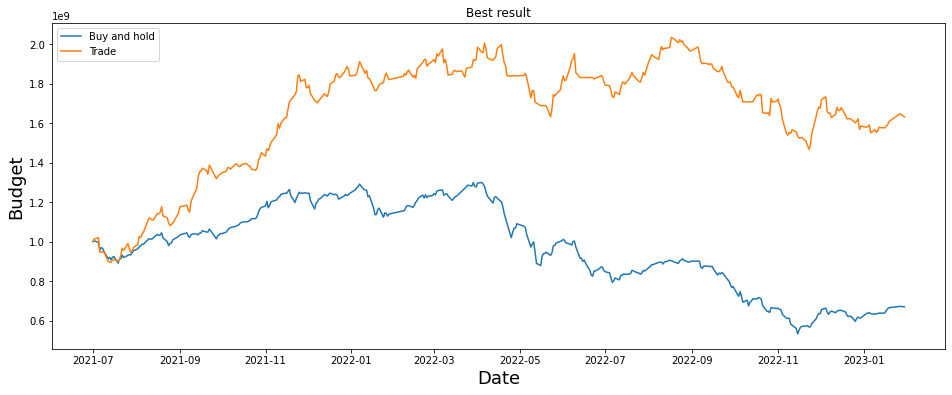

Day 2021-07-01
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-02
Buy 6100 HOSE:HAH at price 32500.0 with pred 1.000
Buy 5400 HOSE:HDB at price 36500.0 with pred 1.000
Buy 5400 HOSE:NKG at price 36800.0 with pred 1.000
Buy 6100 HNX:BVS at price 33100.0 with pred 1.000
Buy 6500 HOSE:MSB at price 31150.0 with pred 1.000
206 / 206 ticker growths
Portfolio
HOSE:HDB : 5400.0, current price: 37200.0, current profit: 1.765%
HOSE:MSB : 6500.0, current price: 31150.0, current profit: -0.150%
HOSE:NKG : 5400.0, current price: 36750.0, current profit: -0.285%
HOSE:HAH : 6100.0, current price: 33500.0, current profit: 2.923%
HNX:BVS : 6100.0, current price: 34000.0, current profit: 2.565%
Portfolio cash: 47317.5, net value: 1013602317.5
Day 2021-07-05
206 / 206 ticker growths
Portfolio
HOSE:HDB : 5400.0, current price: 37400.0, current profit: 2.312%
HOSE:MSB : 6500.0, current price: 31400.0, current profit: 0.652%
HOSE:NKG : 5400.0, current price: 

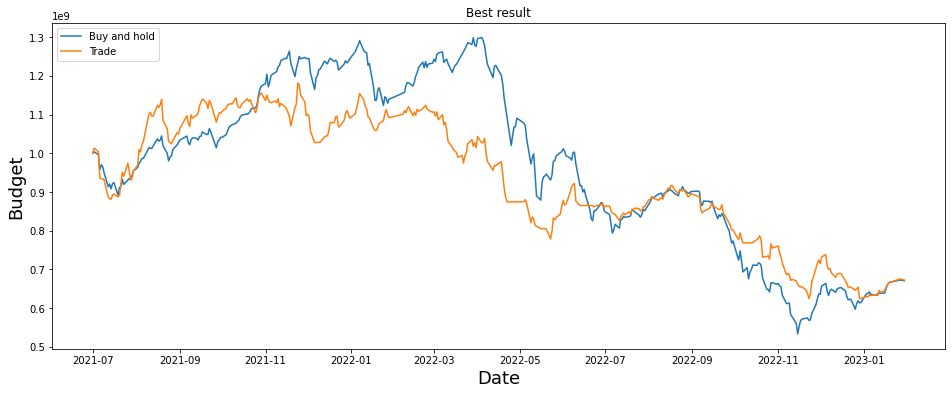

In [14]:
#Visualize the worst and the best scenario
best_index = np.argmax(backtest.final_sharp_ratios)
backtest.visualize(best_index)

print(backtest.logs[best_index])

worst_index = np.argmin(backtest.final_sharp_ratios)
backtest.visualize(worst_index)


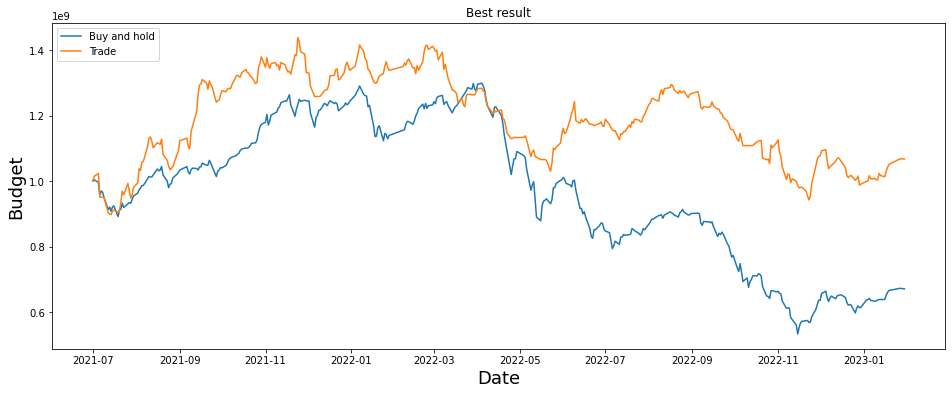

Day 2021-07-01
206 / 206 ticker growths
Portfolio
Portfolio cash: 1000000000, net value: 1000000000
Day 2021-07-02
Buy 6100 HOSE:HAH at price 32500.0 with pred 1.000
Buy 5400 HOSE:NKG at price 36800.0 with pred 1.000
Buy 5400 HOSE:HDB at price 36500.0 with pred 1.000
Buy 5800 HNX:MBS at price 34500.0 with pred 1.000
Buy 6500 HOSE:MSB at price 31150.0 with pred 1.000
206 / 206 ticker growths
Portfolio
HOSE:HDB : 5400.0, current price: 37200.0, current profit: 1.765%
HOSE:MSB : 6500.0, current price: 31150.0, current profit: -0.150%
HOSE:NKG : 5400.0, current price: 36750.0, current profit: -0.285%
HNX:MBS : 5800.0, current price: 35700.0, current profit: 3.323%
HOSE:HAH : 6100.0, current price: 33500.0, current profit: 2.923%
Portfolio cash: 1860032.5, net value: 1015075032.5
Day 2021-07-05
206 / 206 ticker growths
Portfolio
HOSE:HDB : 5400.0, current price: 37400.0, current profit: 2.312%
HOSE:MSB : 6500.0, current price: 31400.0, current profit: 0.652%
HOSE:NKG : 5400.0, current price

In [15]:
#Visualize a random simulation

random_index = random.randint(0,99)
backtest.visualize(random_index)

print(backtest.logs[random_index])

In [16]:
# Export output including the buying and selling signal as a dataframe
output_raw = backtest.env_df[["datetime", "ticker", "open", "high", "close", "low", "volume"]].copy()
output = output_raw.set_index(["datetime", "ticker"])
output["signal"] = 0
for i in range(len(backtest.trade_sessions)):    
    for j in range(len(backtest.tickers)):
        if test_preds[i, j] == 1 and j in backtest.filter.cache[i]:
            print(backtest.trade_sessions[i], backtest.tickers[j])
            output.loc[(backtest.trade_sessions[i], backtest.tickers[j]), "signal"] = 1
            
output = output.reset_index()
output = output.set_index("datetime")
output = output.sort_index(axis = 0)


KeyError: "['datetime'] not in index"

In [ ]:
output_tmp = output.reset_index()
output_tmp = output_tmp.set_index(["ticker"])
output = output.reset_index()
candidates = output[output["signal"] == 1]["ticker"].unique()
output = output.set_index(["datetime", "ticker"])
trade_sessions = list(backtest.trade_sessions)
cut_loss = 0.07
profits = []



for ticker in candidates:
    insight = output_tmp.loc[ticker]
    buy_signals = insight[insight["signal"] == 1]["datetime"]
    for signal in buy_signals:
        
        buy_price = insight[insight["datetime"] == signal]["close"].values[0] 
        print("==================================================")
        print("Processing for buying signal {}, {}, {}".format(ticker, signal, buy_price))
        
        max_high = insight[insight["datetime"] == signal]["high"].values[0]         
        buy_signal_index = trade_sessions.index(signal)
        
        for i in range(buy_signal_index + 1, len(trade_sessions)):
            current_date = trade_sessions[i]
            current_high = insight[insight["datetime"] == current_date]["high"].values[0]        
            current_close = insight[insight["datetime"] == current_date]["close"].values[0]        
            
            if current_high > max_high:
                max_high = current_high
            
            if current_close < max_high * (1 - cut_loss):
                sell_price = max_high * (1 - cut_loss)
                profit = (sell_price / buy_price) - 1
                profits.append(profit)
                print("Selling at {} with price: {}, profit: {:.2f}%".format(current_date, sell_price, profit * 100))
                output.loc[(current_date, ticker), "signal"] = -1
                
                
                break
                
print(np.mean(profits) * 100)

In [ ]:
print(len(output[output["signal"] == -1]))
print(len(output[output["signal"] == 1]))

In [ ]:
output.to_csv("output_2021.csv")            